$\Delta u + k^2(1+q) u = f $ in $\Omega = [0,1]^2$    
$u = 0 $ on $\partial \Omega$

In [9]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres,lgmres
import time

In [10]:
k = 1  # wavenumber
N = 50  # 格点数
h = 1 / N  # 间隔

In [11]:
def q_gen_example(N):
    q = np.zeros((N + 1, N + 1))
    q_value = 0.02
    x1, x2, x3, y1, y2, y3, y4 = 0.2, 0.4, 0.7, 0.2, 0.3, 0.6, 0.7
    q[int(x1 * N):int(x2 * N), int(y1 * N):int(y4 * N)] = q_value
    q[int(x2 * N):int(x3 * N), int(y2 * N):int(y3 * N)] = q_value
    return q

def q_gen_1(N,b1 = 0.3,b2 = 0.6,a1 = 8,a2 = 9,gamma = 1): # 𝑞(𝑥,𝑦)= 𝜆   exp⁡(−𝑎1(𝑥−𝑏1 )^2−a2 (y−b2 )^2 ) 

    q = np.zeros((N + 1, N + 1))
    for i in range(1,N):
        for j in range(1,N):
            q[i,j] = gamma* np.exp(-a1*(i/N - b1)**2-a2*(j/N - b2)**2)
    return q

def q_generation(N, method='T'): 
    if method == 'T':
        return q_gen_example(N)
    elif method == 'Gauss':
        return q_gen_1(N)
    print('method error')


q = q_generation(N)
# sns.heatmap(q, xticklabels=False, yticklabels=False)

$u = \sin(x\pi)\sin(y\pi)$  
$f = \Delta u + (1+q) u = (1+q-2\pi^2)u$

In [12]:
def u_gen(N):
    u = np.zeros((N+1,N+1))
    for i in range(1,N):
        for j in range(1,N):
            u[i,j] = np.sin(i*np.pi/N)*np.sin(j*np.pi/N)  # u(x,y) = sin(\pi x)* sin(\pi y)
    return u

u_truth = u_gen(N)
# sns.heatmap(u_truth, xticklabels=False, yticklabels=False)

In [13]:
def f_gen_1(N,q,u,k = 1):
    return ((1+q)*k*k-2*np.pi*np.pi)*u

f = f_gen_1(N,q,u_truth)
# sns.heatmap(f, xticklabels=False, yticklabels=False)

### 九点格式
$A \,u_{i,j} = u_{i+1,j} +u_{i-1,j} +u_{i,j+1} +u_{i,j-1}  $  
$\frac{A-4I}{h^2} u_{i,j} + k^2(1+q_{i,j})u_{i,j} = f_{i,j} $ 
$B \,u_{i,j} = u_{i+1,j+1} +u_{i-1,j-1} +u_{i-1,j+1} +u_{i+1,j-1}$  
$\frac{A-4I}{h^2} u_{i,j} + \frac{B - 2A+4I}{6h^2}u_{i,j} + k^2(1+q_{i,j})u_{i,j} + \frac{k^2}{12}(A-4I)
(1+q_{i,j})u_{i,j}= f_{i,j} + \frac{1}{12}(A-4I)f_{i,j}$  
$\Rightarrow\quad (B+4A-20I) u_{i,j} +h^2 k^2(0.5A+4I)
(1+q_{i,j})u_{i,j}= h^2 (0.5A+4I)f_{i,j}$

In [14]:
def A(v):
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0
    return v[1:-1, 2:] + v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2]


def Matrix_9(N, q, k=1):
    M = N - 1
    h = 1 / N

    Q = q[1:-1, 1:-1].reshape(1, -1)

    value_1 = (1 + Q) * h * h * k * k * 4 - 20  # 主对角线
    value_2 = 4 + 0.5 * h * h * k * k * (1 + q[1:-1, 1:-1])  # A 三对角线&主对角元三对角线

    data_main = value_1  # 主对角线
    data_main_up = np.reshape(np.c_[np.zeros((M, 1)), value_2[:, :-1]],
                              (1, -1))  # 主对角元上对角线
    data_main_down = np.reshape(np.c_[value_2[:, 1:],
                                      np.zeros((M, 1))], (1, -1))  # 主对角元下对角线
    data_up = np.c_[np.zeros((1, M)), value_2[:-1, :].reshape(1,
                                                              -1)]  # 上对角元对角线
    data_up_up = np.tile(np.insert(np.ones(M - 1), 0, 0),
                         M).reshape(1, -1)  # 上对角元上对角线
    data_up_down = np.tile(np.append(np.ones(M - 1), 0),
                           M).reshape(1, -1)  # 上对角元下对角线
    data_down = np.c_[value_2[1:, :].reshape(1, -1), np.zeros((1, M))]  # 下对角元
    data_down_up = data_up_up  # 下对角元上对角线
    data_down_down = data_up_down  # 下对角元下对角线
    data = np.r_[data_main, data_main_up, data_main_down, data_up, data_up_up,
                 data_up_down, data_down, data_down_up, data_down_down]
    offsets = np.array([0, 1, -1, M, M + 1, M - 1, -M, -M + 1, -M - 1])
    dia = sp.sparse.dia_matrix((data, offsets), shape=(M * M, M * M))
    return dia

In [16]:
def Generate(N,k=1,method = 'Gauss',q_value = None,u_truth = u_truth):
    h = 1/N
    if q_value==None:
        q = q_generation(N,method)
    else:
        q = q_value
    
    f = f_gen_1(N, q, u_truth,k = k)
    Matrix9 = Matrix_9(N, q,k = k)
    Right9 = ((0.5 * A(f) + 4 * f[1:-1, 1:-1]) * h * h).reshape((-1, 1))
    return Matrix9,Right9

def Error(a, a_truth, gap=1e-10):
    a1 = np.where(a < gap, gap, a)
    a_t1 = np.where(a_truth < gap, gap, a_truth)
    return np.abs(a1 / a_t1 - 1)

### 1.N的取值对生成的影响
k = 1

测试用的N_list为:
[32, 64, 128, 256, 512]
g_gen(N)用时为:
[0.002, 0.007, 0.027, 0.106, 0.434]
Generate(N)_T 用时为:
[0.001, 0.001, 0.004, 0.006, 0.025]
Generate(N)_Gauss 用时为:
[0.001, 0.005, 0.02, 0.079, 0.325]


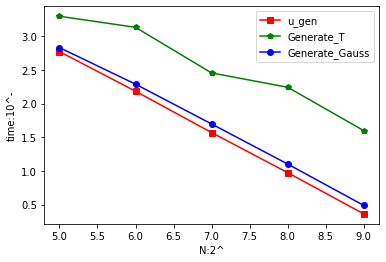

In [68]:
def test_for_gen_time(N_list= [32,64,128,256]):
    time_list1,time_list2,time_list3 = [],[],[]
    for N in N_list:
        time_tmp0 = time.time()
        u_truth = u_gen(N)
        time_tmp1 = time.time()
        time_list1.append(time_tmp1 - time_tmp0)
        Generate(N,method='T',u_truth=u_truth)
        time_tmp2 = time.time()
        time_list2.append(time_tmp2 - time_tmp1)
        Generate(N,method='Gauss',u_truth=u_truth)
        time_list3.append(time.time() - time_tmp2)
    return np.array(time_list1),np.array(time_list2),np.array(time_list3)

times = 100
N_list = [32,64,128,256,512]
res1,res2,res3 = np.zeros(len(N_list)),np.zeros(len(N_list)),np.zeros(len(N_list))
for it in range(times):
    res1+=test_for_gen_time(N_list)[0]
    res2+=test_for_gen_time(N_list)[1]
    res3+=test_for_gen_time(N_list)[2]
res1,res2,res3 = res1/times,res2/times,res3/times
print('测试用的N_list为:')
print(N_list)
print('g_gen(N)用时为:')
print([round(i,3) for i in res1])
print('Generate(N)_T 用时为:')
print([round(i,3) for i in res2])
print('Generate(N)_Gauss 用时为:')
print([round(i,3) for i in res3])

x_axis = np.log2(N_list)
y1 = -np.log10(res1)
y2 = -np.log10(res2)
y3 = -np.log10(res3)
plt.plot(x_axis,y1,'s-',color = 'r',label="u_gen")
plt.plot(x_axis,y2,'p-',color = 'g',label="Generate_T")
plt.plot(x_axis,y3,'o-',color = 'b',label="Generate_Gauss")
plt.xlabel("N:2^")#横坐标名字
plt.ylabel("time:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('')
plt.show()

In [69]:
def perform(N, u_truth = u_truth,q_method = 'T',k = 1,tol=1e-05, inner_m=30,q_value = None):


    Matrix9,Right9 = Generate(N,k,q_method,q_value,u_truth)
    
    # LGMRES
    time90 = time.time()
    u_res, exit = lgmres(Matrix9, Right9, atol=tol,inner_m=inner_m)
    time91 = time.time() - time90
    if exit == 0:
        res9 = np.zeros((N + 1, N + 1))
        res9[1:-1, 1:-1] = u_res.reshape(N - 1, N - 1)
        err90 = np.linalg.norm(Error(res9, u_truth), ord=2) / (N - 1)
    else:
        print('LGMRES不收敛')
    
    #GMRES
    time92 = time.time()
    u_res, exit = gmres(Matrix9, Right9, atol=tol,restart=inner_m)
    time93 = time.time() - time92
    if exit == 0:
        res9 = np.zeros((N + 1, N + 1))
        res9[1:-1, 1:-1] = u_res.reshape(N - 1, N - 1)
        err92 = np.linalg.norm(Error(res9, u_truth), ord=2) / (N - 1)
    else:
        print('GMRES不收敛')
    
    return err90,err92,time91,time93
#     print('N = %d' % N)
#     print('LGMRES平均相对误差为%f,求解用时%f' % (err90, time91))
#     print('GMRES平均相对误差为%f,求解用时%f' % (err92, time93))

In [71]:
def multi_perform(N,times = 2, u_truth = u_truth,q_method = 'T',k = 1,tol=1e-05, inner_m=30,q_value = None):
    LGMRES_err,GMRES_err,LGMRES_time,GMRES_time = [],[],[],[]
    for i in range(times):
        tmp = perform(N,u_truth = u_truth,q_method=q_method,k = k,tol=tol,inner_m=inner_m,q_value=q_value)
        LGMRES_err.append(tmp[0])
        GMRES_err.append(tmp[1])
        LGMRES_time.append(tmp[2])
        GMRES_time.append(tmp[3])
    return sum(LGMRES_err)/times,sum(GMRES_err)/times,sum(LGMRES_time)/times,sum(GMRES_time)/times

### 2.N的取值对求解的影响
k = 1, tol = 1e-05, inner_m = 30

k=1,tol=0.000010,inner_m=30


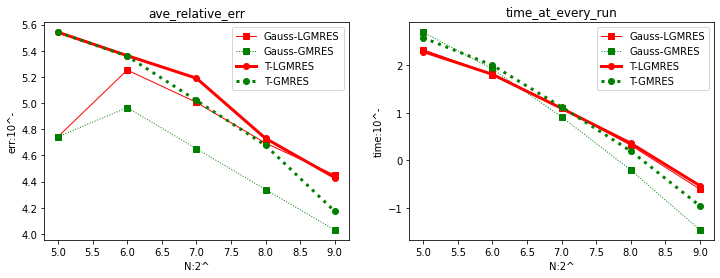

In [96]:
N_list = [32,64,128,256,512]
k = 1
tol = 1e-05
inner_m = 30

print('k=%d,tol=%f,inner_m=%d' % (k,tol,inner_m))
err1,err2,time1,time2 = [],[],[],[]
for N in N_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 10,u_truth = u_truth,q_method='Gauss',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err1.append(tmp[0])
    err2.append(tmp[1])
    time1.append(tmp[2])
    time2.append(tmp[3])

err10,err20,time10,time20 = [],[],[],[]
for N in N_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 10,u_truth = u_truth,q_method='T',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err10.append(tmp[0])
    err20.append(tmp[1])
    time10.append(tmp[2])
    time20.append(tmp[3])
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = np.log2(N_list)


plt.subplot(121)
y1 = -np.log10(err1)
y2 = -np.log10(err2)
y10 = -np.log10(err10)
y20 = -np.log10(err20)
plt.plot(x_axis,y1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,y2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,y10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,y20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("N:2^")#横坐标名字
plt.ylabel("err:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('ave_relative_err')


plt.subplot(122)
t1 = -np.log10(time1)
t2 = -np.log10(time2)
t10 = -np.log10(time10)
t20 = -np.log10(time20)
plt.plot(x_axis,t1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,t2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,t10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,t20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("N:2^")#横坐标名字
plt.ylabel("time:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('time_at_every_run')


plt.show()

### 3.k的取值对求解的影响
N = 100, tol = 1e-5, inner_m = 30

N=100,tol=0.000010,inner_m=30


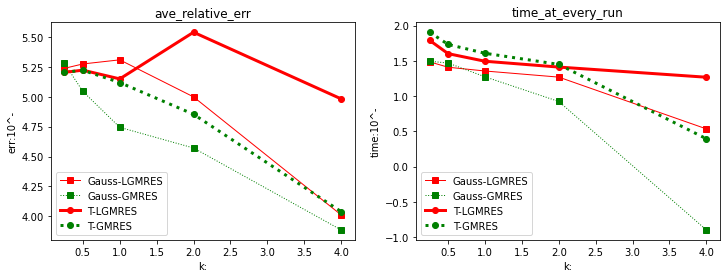

In [107]:
N = 100
tol = 1e-05
inner_m = 30

k_list = [0.25,0.5,1,2,4]
u_truth = u_gen(N)

print('N=%d,tol=%f,inner_m=%d' % (N,tol,inner_m))
err1,err2,time1,time2 = [],[],[],[]
for k in k_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 20,u_truth = u_truth,q_method='Gauss',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err1.append(tmp[0])
    err2.append(tmp[1])
    time1.append(tmp[2])
    time2.append(tmp[3])

err10,err20,time10,time20 = [],[],[],[]
for k in k_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 20,u_truth = u_truth,q_method='T',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err10.append(tmp[0])
    err20.append(tmp[1])
    time10.append(tmp[2])
    time20.append(tmp[3])
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = k_list


plt.subplot(121)
y1 = -np.log10(err1)
y2 = -np.log10(err2)
y10 = -np.log10(err10)
y20 = -np.log10(err20)
plt.plot(x_axis,y1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,y2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,y10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,y20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("k:")#横坐标名字
plt.ylabel("err:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('ave_relative_err')


plt.subplot(122)
t1 = -np.log10(time1)
t2 = -np.log10(time2)
t10 = -np.log10(time10)
t20 = -np.log10(time20)
plt.plot(x_axis,t1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,t2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,t10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,t20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("k:")#横坐标名字
plt.ylabel("time:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('time_at_every_run')


plt.show()


### 4.tol的取值对求解的影响
N = 100, k = 1, inner_m = 30

N=100,k=1.000000,inner_m=30


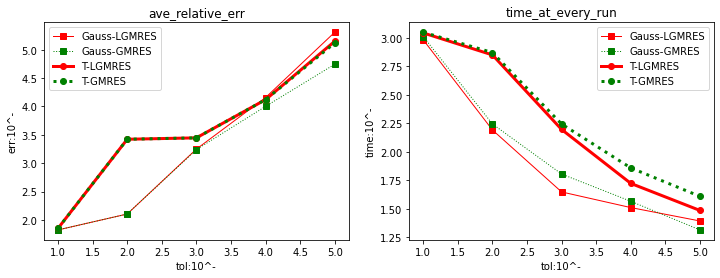

In [109]:
N = 100
k = 1
inner_m = 30

tol_list = [1e-01,1e-02,1e-03,1e-04,1e-05]
u_truth = u_gen(N)

print('N=%d,k=%f,inner_m=%d' % (N,k,inner_m))
err1,err2,time1,time2 = [],[],[],[]
for tol in tol_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 100,u_truth = u_truth,q_method='Gauss',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err1.append(tmp[0])
    err2.append(tmp[1])
    time1.append(tmp[2])
    time2.append(tmp[3])

err10,err20,time10,time20 = [],[],[],[]
for tol in tol_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 100,u_truth = u_truth,q_method='T',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err10.append(tmp[0])
    err20.append(tmp[1])
    time10.append(tmp[2])
    time20.append(tmp[3])
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = -np.log10(tol_list)


plt.subplot(121)
y1 = -np.log10(err1)
y2 = -np.log10(err2)
y10 = -np.log10(err10)
y20 = -np.log10(err20)
plt.plot(x_axis,y1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,y2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,y10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,y20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("tol:10^-")#横坐标名字
plt.ylabel("err:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('ave_relative_err')


plt.subplot(122)
t1 = -np.log10(time1)
t2 = -np.log10(time2)
t10 = -np.log10(time10)
t20 = -np.log10(time20)
plt.plot(x_axis,t1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,t2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,t10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,t20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("tol:10^-")#横坐标名字
plt.ylabel("time:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('time_at_every_run')


plt.show()


### 5.inner_m的取值对求解的影响
N = 100, k = 1, tol = 1e-05

N=100,k=1,tol=0.000010


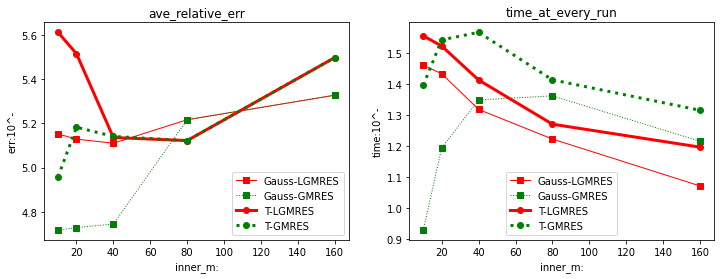

In [112]:
N = 100
k = 1
tol = 1e-05

inner_m_list = [10,20,40,80,160]
u_truth = u_gen(N)

print('N=%d,k=%d,tol=%f' % (N,k,tol))
err1,err2,time1,time2 = [],[],[],[]
for inner_m in inner_m_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 100,u_truth = u_truth,q_method='Gauss',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err1.append(tmp[0])
    err2.append(tmp[1])
    time1.append(tmp[2])
    time2.append(tmp[3])

err10,err20,time10,time20 = [],[],[],[]
for inner_m in inner_m_list:
    u_truth = u_gen(N)
    tmp = multi_perform(N,times = 100,u_truth = u_truth,q_method='T',k = k,tol=tol,inner_m=inner_m,q_value=None)
    err10.append(tmp[0])
    err20.append(tmp[1])
    time10.append(tmp[2])
    time20.append(tmp[3])
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = inner_m_list


plt.subplot(121)
y1 = -np.log10(err1)
y2 = -np.log10(err2)
y10 = -np.log10(err10)
y20 = -np.log10(err20)
plt.plot(x_axis,y1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,y2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,y10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,y20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("inner_m:")#横坐标名字
plt.ylabel("err:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('ave_relative_err')


plt.subplot(122)
t1 = -np.log10(time1)
t2 = -np.log10(time2)
t10 = -np.log10(time10)
t20 = -np.log10(time20)
plt.plot(x_axis,t1,'s-',color = 'r',linewidth = 1,label="Gauss-LGMRES")
plt.plot(x_axis,t2,'s:',color = 'g',linewidth = 1,label="Gauss-GMRES")
plt.plot(x_axis,t10,'o-',color = 'r',linewidth = 3,label="T-LGMRES")
plt.plot(x_axis,t20,'o:',color = 'g',linewidth = 3,label="T-GMRES")
plt.xlabel("inner_m:")#横坐标名字
plt.ylabel("time:10^-")#纵坐标名字
plt.legend(loc = "best")#图例
plt.title('time_at_every_run')


plt.show()
